In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


input_dim = 28*28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
iter = 0
cont = True
epsilon = 0.01
d_loss=[0,0]
epoch=0
while cont:
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % int(len(train_dataset)/batch_size) == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:

                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            print('epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
    d_loss[0] = d_loss[1]
    d_loss[1] = accuracy

    if abs(d_loss[1]-d_loss[0]) < epsilon:        
      correct = 0
      total = 0
      mpred=[]
      mlabel=[]
      for images, labels in test_loader:

          images = images.view(-1, 28*28).to(device)

          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)

          mlabel.append(labels.numpy())
          mpred.append(predicted.numpy())

          total += labels.size(0)

          if torch.cuda.is_available():
              correct += (predicted.cpu() == labels.cpu()).sum()
          else:
              correct += (predicted == labels).sum()

      accuracy = 100 * correct.item() / total
      cont=False
    
    epoch +=1


print('epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))


epoch: 0. Loss: 1.8525100946426392. Accuracy: 69.13
epoch: 1. Loss: 1.4395561218261719. Accuracy: 77.17
epoch: 2. Loss: 1.2393467426300049. Accuracy: 80.07
epoch: 3. Loss: 1.1782748699188232. Accuracy: 81.51
epoch: 4. Loss: 1.0384855270385742. Accuracy: 82.6
epoch: 5. Loss: 0.9813829064369202. Accuracy: 83.42
epoch: 6. Loss: 0.7685767412185669. Accuracy: 83.95
epoch: 7. Loss: 0.7809037566184998. Accuracy: 84.41
epoch: 8. Loss: 0.7196357250213623. Accuracy: 84.94
epoch: 9. Loss: 0.5889792442321777. Accuracy: 85.38
epoch: 10. Loss: 0.7026925086975098. Accuracy: 85.68
epoch: 11. Loss: 0.7570642828941345. Accuracy: 85.92
epoch: 12. Loss: 0.5867767930030823. Accuracy: 86.11
epoch: 13. Loss: 0.7431248426437378. Accuracy: 86.45
epoch: 14. Loss: 0.6662551760673523. Accuracy: 86.68
epoch: 15. Loss: 0.6917967796325684. Accuracy: 86.96
epoch: 16. Loss: 0.5071266293525696. Accuracy: 87.1
epoch: 17. Loss: 0.6925599575042725. Accuracy: 87.23
epoch: 18. Loss: 0.5839080214500427. Accuracy: 87.32
epoch

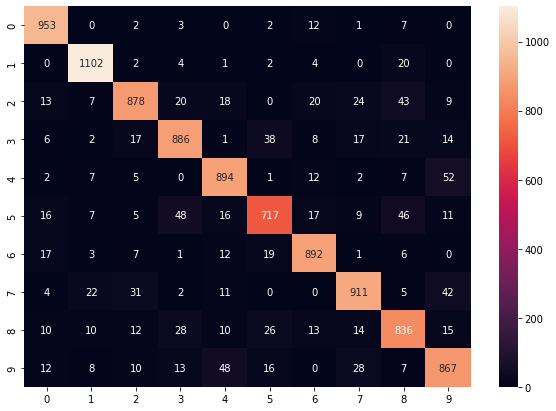

In [ ]:
array = confusion_matrix(np.asarray(mlabel).flatten(),np.asarray(mpred).flatten())
df_cm = pd.DataFrame(array, index = [i
      for i in "0123456789"
   ],
   columns = [i
      for i in "0123456789"
   ])
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, annot = True,fmt='g')